# "um produto orientado a dados governamentais: parte 3"
> "tropeços, quedas e frustrações. Um relato do que não deu certo no projeto."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [machine learning, data science, data product]
- image: images/posts/govdata_poc_3/govdata_poc_minor_p3.png
- hide: false
- search_exclude: true

Esse é o quarto post de uma série de como construir um produto *data-driven* de ponta a ponta, caso você ainda não tenha acompanhado os demais, abaixo segue uma síntese com os respectivos links 😀.
 1. Em [metadados de normas jurídicas federais]({{ site.baseurl }}{% link _posts/2020-07-07-metadados-normativos-federais.md %}) coletamos dados do sistema LexML.
 2. Em [um produto orientado a dados governamentais: parte 1]({{ site.baseurl }}{% link _posts/2020-07-12-gov-data-product.md%}) realizamos uma análise exploratória dos dados e definimos um recorte e um escopo para os dados do projeto.
 3. Em [um produto orientado a dados governamentais: parte 2]({{ site.baseurl }}{% link _posts/2020-07-20-gov-data-product-p2.md%}) realizamos a definição dos dos datasets de treino, validação e teste

In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
#hide
#setup inicial de algmas configurações 
default_color_1 = '#323443'
default_color_2 = '#E7997A'

In [3]:
#hide
from nltk import FreqDist, word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss
from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from IPython.display import display
import re
import unicodedata
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from typing import Tuple

In [4]:
#hide
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
#hide
def transf_str_into_list(texto: str) -> list:
    texto = str(texto)
    texto = texto.split('[')[1].split(']')[0].split(',')
    texto = [w.replace('[','').replace(']','').replace("'","").replace('(','').replace(')','').strip() for w in texto]
    return texto

No último [post]({{ site.baseurl }}{% link _posts/2020-07-20-gov-data-product-p2.md %}) segmentamos nossos dados em conjunto de treinamento, validação e teste que serão utilizados para diferentes finalidades ao longo do processo de treinamento do nosso modelo de aprendizado de máquina.

In [6]:
xTrain = pd.read_csv("./data/xTrain.csv", sep=';').set_index('legislationIdentifier')
yTrain = pd.read_csv("./data/yTrain.csv", sep=';').set_index('legislationIdentifier')

null_description = xTrain[xTrain['description'].isnull()].index
xTrain = xTrain.drop(null_description)
yTrain = yTrain.drop(null_description)

xValidation = pd.read_csv("./data/xValidate.csv", sep=';').set_index('legislationIdentifier')
yValidation = pd.read_csv("./data/yValidate.csv", sep=';').set_index('legislationIdentifier')

null_description = xValidation[xValidation['description'].isnull()].index
xValidation = xValidation.drop(null_description)
yValidation = yValidation.drop(null_description)

yTrain['keywords'] = yTrain['keywords'].apply(transf_str_into_list)
yValidation['keywords'] = yValidation['keywords'].apply(transf_str_into_list)

Vamos iniciar nosso processo de treinamento, instanciando o `TfidfVectorizer` que irá construir uma [`DTM`](https://en.wikipedia.org/wiki/Document-term_matrix) e depois matrix [`TF-IDF`](https://pt.wikipedia.org/wiki/Tf%E2%80%93idf) das `ementas` das normas jurídicas que estamos trabalhando.

In [11]:
#pré processamento
vect = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    tokenizer=word_tokenize,
    max_features=5000)
multilabel = MultiLabelBinarizer()

Aplicamos as transformações nos dados de treinamento e validação.

In [12]:
yValidation_transformed = multilabel.fit_transform(yValidation['keywords'])
xValidation_transformed = vect.fit_transform(xValidation['description'])

In [13]:
%%time
yTrain_transformed = multilabel.fit_transform(yTrain['keywords'])
xTrain_transformed = vect.fit_transform(xTrain['description'])

Wall time: 6.03 s


Em seguida, vamos criar um *`baseline`* para nosso problema de classificação multilabel. Escolhemos a `Regressão Logística` como ponto de partida do nosso trabalho.

### Regressão Logística (*baseline*)

In [14]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xTrain_transformed, yTrain_transformed)

OneVsRestClassifier(estimator=LogisticRegression())

In [15]:
y_pred = clf.predict(xValidation_transformed)

Para o caso de classificações multilabel o `hamming loss`, diferentemente, da função [Zero one loss](https://scikit-learn.org/stable/modules/model_evaluation.html#zero-one-loss) não penaliza um predição caso essa não seja idêntica ao set alvo, isto é, não precisamos de um match exato, portanto, ela apenas penaliza labels de forma individual. Por exemplo, um normativo que possui as seguintes tags: \[`CREDITO SUPLEMENTAR`, `REFORÇO`, `ORÇAMENTO DA SEGURIDADE SOCIAL`, `DOTAÇÃO ORÇAMENTARIA`], mas foi classificado apenas como \[`CREDITO SUPLEMENTAR`, `REFORÇO`, `ORÇAMENTO DA SEGURIDADE SOCIAL`] resultará num hamming_loss de **0.25**. Os valores de `hamming loss` pertencem a um intervalo de 0 a 1 e quanto menor o valor, melhor. Para maiores informações. o leitor pode consultar a [documentação do sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html).

In [16]:
def print_hamming_loss(y_true, y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_true, y_pred)))

In [17]:
print_hamming_loss(yValidation_transformed, y_pred, clf)

Clf:  OneVsRestClassifier
Hamming loss: 0.10763268211658625


Apesar de nossa métrica de avaliação ter resultado num valor baixo, que é o desejável, ela ainda pode ser considerada uma variante de uma métrica de `acurácia`. Portanto, é sabido que em cenários onde o modelo pode predizer apenas a classe majoritária, teremos um score razoável, apesar de não ser considerado um bom modelo. Dito isso, vamos determinar em quantas ocorrências o modelo não resultou em predição nenhuma, isto é, o normativo tem N tags, mas o retorno do modelo foi ausente (0 tags preditas).

In [18]:
len([data for data in y_pred if ~data.any()])/y_pred.shape[0]

0.9648079306071871

<center><div class="tenor-gif-embed" data-postid="9361819" data-share-method="host" data-width="100%" data-aspect-ratio="1.8582089552238805"><a href="https://tenor.com/view/what-gif-9361819">Minion What GIF</a> from <a href="https://tenor.com/search/minion-gifs">Minion GIFs</a></div><script type="text/javascript" async src="https://tenor.com/embed.js"></script></center>

O modelo apesar de um `hamming loss` razoável, em **96,5%** das predições não retorna `tag` alguma. Como exemplificado abaixo:

`Exemplo de resultado esperado:`

In [24]:
multilabel.inverse_transform(np.atleast_2d(yValidation_transformed[0]))

[('AREA PRIORITARIA',
  'DECLARAÇÃO',
  'DESAPROPRIAÇÃO',
  'DESTINAÇÃO',
  'ESTADO DE MINAS GERAIS MG',
  'IMOVEL RURAL',
  'INSTITUTO NACIONAL DE COLONIZAÇÃO E REFORMA AGRARIA INCRA',
  'INTERESSE SOCIAL',
  'MUNICIPIO',
  'REFORMA AGRARIA')]

`Predição realizada:`

In [25]:
multilabel.inverse_transform(np.atleast_2d(y_pred[1]))

[()]

Podemos realizar uma inspeção mais detalhada utilizando a função `classification_report`. Assim, temos evidenciado que a grande maioria das `tags` temos tanto `precision` como `recall` nulos, que no nosso caso em específico podemos interpretar que o modelo não teve capacidade de predição para nenhuma dessas ocorrências.

In [22]:
mapping_tags = list(multilabel.classes_)
print(classification_report(yValidation_transformed, y_pred, target_names=mapping_tags, zero_division=0))

                                                           precision    recall  f1-score   support

                                     ACORDO INTERNACIONAL       0.00      0.00      0.00       505
                                                ALTERAÇÃO       0.00      0.00      0.00      1018
                                                   AMBITO       0.00      0.00      0.00       406
                                                APROVAÇÃO       0.00      0.00      0.00      1944
                                         AREA PRIORITARIA       0.00      0.00      0.00       783
                                                      ATO       0.00      0.00      0.00      1465
                                              AUTORIZAÇÃO       0.00      0.00      0.00       835
                                                   BRASIL       0.00      0.00      0.00       413
                                              COMPETENCIA       0.00      0.00      0.00       445
         

## Pré-Processamento & Engenharia de Atributos (*Feature Engineering*)

### Pré-Processamento

No presente momento, as nossas únicas variáveis preditoras são os tokens oriundos das ementas dos normativos que são submetidos a um pipeline que inicialmente os convertem a uma [matrix DTM](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) e por conseguinte os transformam em uma representação [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer). Para esse conjunto de operações a biblioteca sklearn fornece a classe [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) que realiza esse conjunto de operações.

Para que seja possível fazer uma inspeção das nossas variáveis preditoras, iremos recorrer a uma **wordcloud** para ter uma dimensão da frequência de ocorrência dos diferentes tokens no corpus em análise.

In [11]:
def make_word_cloud(series: pd.Series, **kwargs):
    stopwords = kwargs.get('stopwords')
    corpus_normativos = " ".join(series)
    tokenize_corpus = word_tokenize(corpus_normativos)
    if stopwords:
        print(len(stopwords))
        wordcloud = WordCloud(width=1024, height=768, stopwords=stopwords, margin=0).generate(corpus_normativos)
    else:
        wordcloud = WordCloud(width=1024, height=768, margin=0).generate(corpus_normativos)
    #show
    plt.figure(figsize=[15, 9])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud

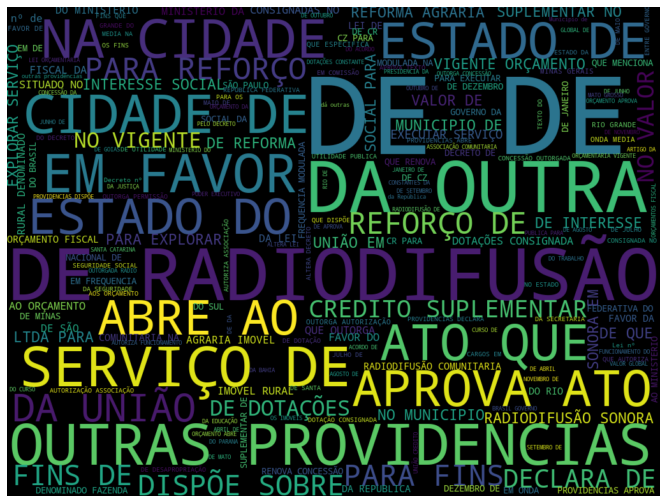

In [63]:
wc = make_word_cloud(xTrain['description'])

In [12]:
#collapse
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
df_common_words = pd.DataFrame(get_top_n_words(xTrain['description']), columns = ['token' , 'frequencia'])

Pelo gráfico abaixo que inspecionamos os 30 tokens mais frequentes no corpus de treinamento, identificamos que muitos destes são considerados [stop words](https://en.wikipedia.org/wiki/Stop_words), bem como há ocorrências de numerais. Dito isso, o próximo passo do nosso pipeline de pré-processamento será compostos pelas seguintas etapas:
 - Remoção de um conjunto delimitado de stopwords;
 - Excluir tokens que sejam compostos exclusivamente de dígitos;
 - Normalizar os tokens de forma a retirar acentos e caracteres especiais.
 - Correção de grafia de tokens

In [131]:
#collapse
alt.Chart(df_common_words[:30].sort_values(by='frequencia', ascending=False)).mark_bar().encode(
    alt.X('frequencia:Q', title='Frequência'),
    alt.Y("token:N", sort='-x'),
    tooltip=[alt.Tooltip('frequencia', title='Frequência')]
    )\
    .properties(height=500)\
    .configure_mark(color=default_color_2)    

alt.Chart(...)

#### a) Remoção de um conjunto delimitado de stopwords

Vamos utilizar uma lista compiladas de stopwords listadas nesse [GIST](https://gist.github.com/alopes/5358189).

In [17]:
#hide
#https://gist.github.com/alopes/5358189
stopwords = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']

#### b) Excluir tokens que sejam compostos exclusivamente de dígitos.

In [18]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

#### c) Normalizar os tokens de forma a retirar acentos e caracteres especiais.

In [19]:
def removerAcentosECaracteresEspeciais(palavra):
    # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    #retirar espaços vazios múltiplos
    palavraSemAcento = re.sub(' +', ' ', palavraSemAcento)
    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento).lower()

#### d) Correção de grafia de tokens

Nessa etapa faremos a correção da ocorrência de alguns tokens que estão com grafia incorreta, ou duas palavras que não estão separadas por espaço, ou mesmo palavras no plural que vamos transformá-la para o singular.

In [20]:
#collapse
def split_selected_tokens(texto: str):
    select_tokens = {
        'dedezembro' : 'de dezembro',
        'capitalsocial' : 'capital social',
        'decretosleis' : 'decretos leis',
        'nacionaldestinada' : 'nacional destinada',
        'professorequivalente' : 'professor equivalente',
        'tvsbt' : 'tv sbt',
        'orcamentariavigente' : 'orcamentaria vigente',
        'tecnicoprofissional' : 'tecnico profissional',
        'republicafederativa' : 'republica federativa', 
        'transbrasilianaconcessionaria' : 'transbrasiliana concessionaria',
        'publicoprivada' : 'publico privada',
        'procuradorgeral' : 'procurador geral',
        'auditoriafiscal' : 'auditoria fiscal',
        'decretoslei' : 'decretos lei',
        'segurancapublica' : 'seguranca publica',
        'novadutra' : 'nova dutra',
        'queespecifica' : 'que especifica',
        'agenciasreguladoras' : 'agencias reguladoras',
        'autopistalitoral' : 'autopista litoral',
        'goiasvigencia' : 'goias vigencia',
        'governadorcelso' : 'governador celso',
        'autopistaregis' :'autopista regis',
        'valecultura' : 'vale cultura',
        'programacaoorcamentaria' : 'programacao orcamentaria',
        'dopoder' : 'do poder',
        'ministeriodo' : 'ministerio do',
        'estadosmembros' : 'estados membros',
        'papelmoeda' :'papel moeda',
        'bolsaatleta' : 'bolsa atleta',
        'complementacaoeconomica' : 'complementacao economica',
        'artisticoculturais' :'artistico culturais',
        'conselhogeral' : 'conselho geral',
        'tecnicoadministrativos' : 'tecnico administrativos',
        'registradosacrescentando' : 'registrado sacrescentando',
        'ruralcontratadas' : 'rural contratadas',
        'estudantesconvenio' : 'estudantes convenio',
        'delegadode' : 'delegado de',
        'junhode' : 'junho de',
        'denovembro' : 'de novembro',
        'lavourapecuariafloresta' : 'lavoura pecuaria floresta',
        'autorizadaaltera' : 'autorizada altera',
        'grupodefesa' : 'grupo defesa',
        'contribuicoesprevidenciarias' : 'contribuicoes previdenciarias',
        'cpfgce' : 'cpf gce',
        'empregose' : 'empregos e',
        'dosanistiados' : 'dos anistiados',
        'antigomobilismo' : 'antigo mobilismo',
        'dogrupodirecao' : 'do grupo direcao',
        'milhoestrezentos' : 'milhoes trezentos',
        'deavaliacao' : 'de avaliacao',
        'salariominimo' : 'salario minimo',
        'imoveis' : 'imovel',
        'grupodirecao' : 'grupo direcao',
        'pispasep' : 'pis pasep',
        'rurais' : 'rural'
    }
    new_text = texto.split(" ")
    container =[]
    for word in new_text:
        if word in select_tokens.keys():
            container.append(select_tokens[word])
        else:
            container.append(word)
    return " ".join(container)

#### Função de pré-processamento

Por fim, vamos consolidar uma função que agrega as nossas etapas de pré-processamento.

In [21]:
def pre_processing_pipeline(texto:str):
    texto = " ".join([token for token in word_tokenize(removerAcentosECaracteresEspeciais(texto)) if not token.isdigit()])

    texto = " ".join([token for token in word_tokenize(texto) if not hasNumbers(token)])

    texto = " ".join([token for token in word_tokenize(texto) if len(token) > 2])
    texto = " ".join([split_selected_tokens(token) for token in word_tokenize(texto) if not token.isdigit()])
    return texto

Vamos retirar acentos e caracteres especiais do nosso conjunto de *stopwords*.

In [22]:
stopwords_2 = []
for word in stopwords: 
    stopwords_2.append(removerAcentosECaracteresEspeciais(word))

### Feature Engineering

Uma vez determinado alguns passos adicionais de `pré-processamento`, podemos avaliar a construção de algumas novas features para serem incorporadas ao nosso modelo de dados. Inicialmente, vamos analisar como se distribuem o tamanho das ementas do nosso conjunto de treinamento.

In [107]:
text_size = pd.DataFrame(xTrain['description'].str.len()).rename(columns={'description' : 'size'}).reset_index()

In [128]:
#hide_input
alt.Chart(text_size).mark_bar().encode(
    alt.X("size", bin=alt.Bin(extent=[0, int(np.quantile(text_size['size'], 0.99))+1], step=100), title='Tamanho da ementa'),
    alt.Y('count()', title='N° de ocorrências'), tooltip=[alt.Tooltip('count()', title='N° de ocorrências')])\
    .properties(height=400, width=400)\
    .configure_mark(color=default_color_2)    

alt.Chart(...)

O histograma informa que temos ementas com menos de 100 caracterters até algumas com mais de 500, podemos explorar essa diversidade de tamanhos como uma possível feature, por exemplo. Além disso, há outras características dos tokens que podem conferir informações que o modelo poderá usar para realizar a predição. Assim, iremos escrever algumas funções que irão nos auxiliar a consolidar novas features.

In [26]:
#collapse
def add_new_text_features(dataframe: pd.DataFrame) -> pd.DataFrame:
    df = dataframe.copy()
    df['total_length'] = df['description'].apply(len)
    df['num_punctuation'] = df['description'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['description'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words'] = df['description'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['description'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    return df

def add_datepart(dataframe, fldname, drop=True):
    """Função modificada da fast.ai"""
    df = dataframe.copy()
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)
    for col in ['Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end',
       'Is_year_start']:
        df[targ_pre+col] = df[targ_pre+col].map({True: 1, False: 0})
    return df

def train_cats(dataframe):
    """
    *** função modificada da fast.ai ***
    Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
	"""
    df = dataframe.copy()
    for n,c in df.items():
        if is_string_dtype(c) and (n != 'description' and n != 'datePublished'): 
            df[n] = c.astype('category').cat.as_ordered()
    return df

def apply_cats(dataframe: pd.DataFrame, trn: pd.DataFrame):
    """
    *** função modificada da fast.ai ***
    Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes for df.
    """
    df = dataframe.copy()
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)
    return df

def numericalize(dataframe, col: pd.Series, name, max_n_cat=None):
    """
    *** função modificada da fast.ai ***
    Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    """
    df = dataframe.copy()
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
    return df

def pipeline_for_feature_eng(train_data: Tuple[pd.DataFrame, pd.DataFrame], mode: str, vect: TfidfVectorizer, multilabel: MultiLabelBinarizer, test_data: Tuple[pd.DataFrame, pd.DataFrame] = None):
    if mode == 'train':
        xTrain = train_data[0]
        yTrain = train_data[1]
        df_train = add_new_text_features(xTrain)
        df_train = train_cats(df_train)
        df_train = numericalize(df_train, df_train.legislationType, 'NUM_legislationType')
        df_train = add_datepart(df_train, 'datePublished')
        yTrain_transformed = multilabel.fit_transform(yTrain['keywords'])
        dtm_only_tokens = vect.fit_transform(df_train['description'])
        dtm_tokens_to_df = pd.DataFrame(dtm_only_tokens.toarray(), columns=vect.get_feature_names())
        dtm_tokens_to_df['legislationIdentifier'] = yTrain.index
        dtm_tokens_to_df.set_index('legislationIdentifier', inplace=True)
        xTrain_with_newft = df_train.merge(dtm_tokens_to_df, how='left', left_index=True, right_index=True).drop(['legislationType', 'description'], axis='columns')
        return xTrain_with_newft, yTrain_transformed, vect, multilabel
    if mode == 'test' or mode == 'validation':
        xTest = test_data[0]
        yTest = test_data[1]
        xTrain = train_data[0]
        df_test = add_new_text_features(xTest)
        df_test = apply_cats(df_test, xTrain)
        df_test = numericalize(df_test, df_test.legislationType, 'NUM_legislationType')
        df_test = add_datepart(df_test, 'datePublished')
        yTest_transformed = multilabel.fit_transform(yTest['keywords'])
        dtm_only_tokens = vect.fit_transform(df_test['description'])
        dtm_tokens_to_df = pd.DataFrame(dtm_only_tokens.toarray(), columns=vect.get_feature_names())
        dtm_tokens_to_df['legislationIdentifier'] = yTest.index
        dtm_tokens_to_df.set_index('legislationIdentifier', inplace=True)
        xTest_with_newft = df_test.merge(dtm_tokens_to_df, how='left', left_index=True, right_index=True).drop(['legislationType', 'description'], axis='columns')
        return xTest_with_newft, yTest_transformed

Assim, podemos conduzir as transformações necessárias no conjunto de treinamento e validação.

In [27]:
#pré processamento
vect = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    tokenizer=word_tokenize,
    max_features=5000,
    preprocessor=pre_processing_pipeline,
    stop_words=stopwords_2)
multilabel = MultiLabelBinarizer()

In [28]:
%%time
xTrain_with_newft, yTrain_transformed, vect, multilabel = pipeline_for_feature_eng((xTrain, yTrain), mode='train', vect=vect, multilabel=multilabel)

Wall time: 25 s


In [29]:
%%time
xValidation_with_newft, yValidation_transformed = pipeline_for_feature_eng((xTrain,), mode='test', vect=vect, multilabel=multilabel, test_data=(xValidation, yValidation))

Wall time: 10.8 s


Ao que parece temos um estratágia vencedora para melhorar a performance do nosso modelo.

<div class="tenor-gif-embed" data-postid="7228108" data-share-method="host" data-width="100%" data-aspect-ratio="1.2258064516129032"><a href="https://tenor.com/view/hacking-essay-group-assignment-computer-gif-7228108">Hacking Essay GIF</a> from <a href="https://tenor.com/search/hacking-gifs">Hacking GIFs</a></div><script type="text/javascript" async src="https://tenor.com/embed.js"></script>

Novamente, iremos instanciar um novo estimador e iniciar vamos avaliar se as novas etapas de `pré-processamento` e `feature engineering` beneficaram o modelo.

In [299]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xTrain_with_newft, yTrain_transformed)

OneVsRestClassifier(estimator=LogisticRegression())

In [301]:
y_pred = clf.predict(xValidation_with_newft)

Ao que parece o feature engineering não surtiu muito efeito no `Hamming loss`. Mesmo assim devemos conferir o desempenho na `métrica f1`.

In [302]:
print_hamming_loss(yValidation_transformed, y_pred, clf)

Clf:  OneVsRestClassifier
Hamming loss: 0.10762477260143953


**Olha o relatório!** 😲😲😲😲 Com a inclusão das novas features, para regressão logística na realidade houve uma inclusão de ruído, do que propriarmente amplificação do sinal para que o modelo pudesse realizar a predição de forma adequada. Acho melhor seguirmos para avaliar um outro modelo ...

In [306]:
print(classification_report(yValidation_transformed, y_pred, target_names=mapping_tags, zero_division=0))

                                                           precision    recall  f1-score   support

                                     ACORDO INTERNACIONAL       0.00      0.00      0.00       505
                                                ALTERAÇÃO       0.00      0.00      0.00      1018
                                                   AMBITO       0.00      0.00      0.00       406
                                                APROVAÇÃO       0.00      0.00      0.00      1944
                                         AREA PRIORITARIA       0.00      0.00      0.00       783
                                                      ATO       0.00      0.00      0.00      1465
                                              AUTORIZAÇÃO       0.00      0.00      0.00       835
                                                   BRASIL       0.00      0.00      0.00       413
                                              COMPETENCIA       0.00      0.00      0.00       445
         

### Random Forest

Vamos partir para avaliar nossos dados com 🌳`RandomForest`🎲 que é considerado um ensemble de `Decision Trees`🌳.

In [309]:
#instancia o classificador
clf = RandomForestClassifier(
    n_estimators=10, 
    min_samples_leaf= 1,
    max_features=0.5,
    class_weight=None,
    bootstrap=True,
    oob_score=True
)

In [310]:
clf.fit(xTrain_with_newft, yTrain_transformed)

D:\opensource\gov-data-product\.venv\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\opensource\gov-data-product\.venv\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(max_features=0.5, n_estimators=10, oob_score=True)

Inspecionando o `oob score` - que é o erro médio calculado para cada predição a partir das árvores que não fazem parte da respectiva amostragem boostrap, para maiores detalhes ler a documentação [aqui](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) - temos um sinal favorável de uma performance melhor do que tivemos até o momento.

In [311]:
clf.oob_score_

0.9833852508934451

Todavia, como recebemos um warning na hora do `fit` do modelo, informando que é possível que não tenhamos uma estimativa confiável do `oob score`, devido a um número pequeno de arvóres (`n=10`) para realizar o cálculo, então é melhor verificarmos outras métricas. Vamos avaliar o modelo com os nosso cojunto de `validação`.

In [313]:
y_pred = clf.predict(xValidation_with_newft)

In [314]:
print_hamming_loss(yValidation_transformed, y_pred, clf)

Clf:  RandomForestClassifier
Hamming loss: 0.10424740963378945


Tivemos uma leve melhora do `hamming loss`, todavia, o nosso `f1-micro` marcou apenas míseros `0.13` 😥. Precisamos continuar trabalhando na melhoria do nosso modelo 👷.

In [315]:
print(classification_report(yValidation_transformed, y_pred, target_names=mapping_tags, zero_division=0))

                                                           precision    recall  f1-score   support

                                     ACORDO INTERNACIONAL       0.67      0.00      0.01       505
                                                ALTERAÇÃO       0.07      0.00      0.00      1018
                                                   AMBITO       0.07      0.00      0.01       406
                                                APROVAÇÃO       1.00      0.00      0.00      1944
                                         AREA PRIORITARIA       0.00      0.00      0.00       783
                                                      ATO       0.00      0.00      0.00      1465
                                              AUTORIZAÇÃO       0.08      0.00      0.01       835
                                                   BRASIL       0.00      0.00      0.00       413
                                              COMPETENCIA       0.00      0.00      0.00       445
         

### Feature Importance

Vamos dar continuidade a nossa saga de desenvolver um produto data-driven orientados por dados governamentais, a partir da análise das `feature importance` do nosso modelo.

In [29]:
def rf_feat_importance(m, df):
    """*** função da fastai"""
    return pd.DataFrame({'feature':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [322]:
features_analise = pd.DataFrame(xTrain_with_newft)
feature_importances = rf_feat_importance(clf, features_analise)

Pela análise do gráfico abaixo, a boa notícia é que algumas das features criadas, como `datePublishedElapsed` e `datePublishedYear` parecem estar ajudando o modelo no trabalho de predição.

In [328]:
#hide_input
alt.Chart(feature_importances[:50]).mark_bar().encode(
    alt.X('imp:Q', title='Feature Importance'),
    alt.Y("feature:N", sort='-x'),
    tooltip=[alt.Tooltip('imp', title='Feature Importance')]
    )\
    .properties(height=800, width=600)\
    .configure_mark(color=default_color_2)    

alt.Chart(...)

A próxima experimentação é para validar a seguinte premissa: É possível que temos `features` demais no nosso modelo? Assim, iremos manter as features criadas e iremos realizar um corte nos tokens que possuem uma `feature importance` menor que **0.001**.

In [336]:
#collapse
num_features = {'total_length', 'num_punctuation', 'num_symbols', 'num_words',
       'num_unique_words', 'words_vs_unique', 'NUM_legislationType',
       'datePublishedYear', 'datePublishedMonth', 'datePublishedWeek',
       'datePublishedDay', 'datePublishedDayofweek', 'datePublishedDayofyear',
       'datePublishedIs_month_end', 'datePublishedIs_month_start',
       'datePublishedIs_quarter_end', 'datePublishedIs_quarter_start',
       'datePublishedIs_year_end', 'datePublishedIs_year_start',
       'datePublishedElapsed'}
new_stop_words = list(set(feature_importances[feature_importances['imp'] <= 0.001]['feature'].unique())-num_features)
stopwords_3 = stopwords_2.copy()
stopwords_3.extend(new_stop_words)

Dessa forma, iremos instanciar novamente o `TfidfVectorizer` limitando o processo de vetorização a 1000 `features` e passando uma lista de stopwords que inclua aqueles tokens que tiverem `feature importance` menor que **0.001**.

In [369]:
#pré processamento
vect = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    tokenizer=word_tokenize,
    max_features=1000,
    preprocessor=pre_processing_pipeline,
    stop_words=stopwords_3)
multilabel = MultiLabelBinarizer()

In [370]:
xTrain_with_newft, yTrain_transformed, vect, multilabel = pipeline_for_feature_eng((xTrain, yTrain), mode='train', vect=vect, multilabel=multilabel)
xValidation_with_newft, yValidation_transformed = pipeline_for_feature_eng((xTrain,), mode='test', vect=vect, multilabel=multilabel, test_data=(xValidation, yValidation))

Procedemos instanciando um novo `RandomForestClassifier` só que dessa vez aumentamos o número de estimadores para `60`. Em seguida, procedemos com a avaliação dos efeitos das nossas modificações.

In [378]:
#instancia o classificador
clf = RandomForestClassifier(
    n_estimators=60, 
    min_samples_leaf= 1,
    max_features=0.5,
    class_weight=None,
    bootstrap=True
)

In [379]:
clf.fit(xTrain_with_newft, yTrain_transformed)
y_pred = clf.predict(xValidation_with_newft)

RandomForestClassifier(max_features=0.5, n_estimators=60)

<div class="tenor-gif-embed" data-postid="7443411" data-share-method="host" data-width="100%" data-aspect-ratio="1.4678899082568808"><a href="https://tenor.com/view/shocked-gif-7443411">So Shocked GIF</a> from <a href="https://tenor.com/search/shocked-gifs">Shocked GIFs</a></div><script type="text/javascript" async src="https://tenor.com/embed.js"></script>

In [381]:
print_hamming_loss(yValidation_transformed, y_pred, clf)

Clf:  RandomForestClassifier
Hamming loss: 0.10842890664135622


In [382]:
print(classification_report(yValidation_transformed, y_pred, target_names=mapping_tags, zero_division=0))

                                                           precision    recall  f1-score   support

                                     ACORDO INTERNACIONAL       0.00      0.00      0.00       505
                                                ALTERAÇÃO       0.33      0.01      0.01      1018
                                                   AMBITO       0.13      0.00      0.01       406
                                                APROVAÇÃO       0.50      0.00      0.00      1944
                                         AREA PRIORITARIA       0.00      0.00      0.00       783
                                                      ATO       0.00      0.00      0.00      1465
                                              AUTORIZAÇÃO       0.17      0.03      0.05       835
                                                   BRASIL       0.00      0.00      0.00       413
                                              COMPETENCIA       0.00      0.00      0.00       445
         

É melhor seguir em frente e não pensar muito nessa tragédia ... 😕

### ExtraTreesClassifier 🌳🔀

Uma das possíveis causas do nosso desempenho ruim, pode ser devido a um `overfitting`. Assim, iremos recorrer a uma variante da RandomForest implementada pelo sklearn chamado [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) que diminui possíveis efeitos de `overfitting`.

In [405]:
#instancia o classificador
clf = ExtraTreesClassifier(
    min_samples_leaf= 3,
    max_features=0.5,
    n_jobs=-1
)

In [408]:
#collapse
vect = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    tokenizer=word_tokenize,
    max_features=5000,
    preprocessor=pre_processing_pipeline,
    stop_words=stopwords_2)
multilabel = MultiLabelBinarizer()

In [ ]:
#collapse
xTrain_with_newft, yTrain_transformed, vect, multilabel = pipeline_for_feature_eng((xTrain, yTrain), mode='train', vect=vect, multilabel=multilabel)
xValidation_with_newft, yValidation_transformed = pipeline_for_feature_eng((xTrain,), mode='test', vect=vect, multilabel=multilabel, test_data=(xValidation, yValidation))
clf.fit(xTrain_with_newft, yTrain_transformed)
y_pred = clf.predict(xValidation_with_newft)

In [412]:
#hide
print_hamming_loss(yValidation_transformed, y_pred, clf)

Clf:  ExtraTreesClassifier
Hamming loss: 0.10352237074533997


Infelizmente, nosso modelo cotinua com um um desempenho pífio. Em **85%** das predições são nulas. Além disso, registramos um `f1-micro` de **0.08**.

In [413]:
len([data for data in y_pred if ~data.any()])/y_pred.shape[0]

0.8542750929368029

In [414]:
print(classification_report(yValidation_transformed, y_pred, target_names=mapping_tags, zero_division=0))

                                                           precision    recall  f1-score   support

                                     ACORDO INTERNACIONAL       0.29      0.00      0.01       505
                                                ALTERAÇÃO       0.23      0.01      0.01      1018
                                                   AMBITO       0.00      0.00      0.00       406
                                                APROVAÇÃO       1.00      0.00      0.00      1944
                                         AREA PRIORITARIA       0.00      0.00      0.00       783
                                                      ATO       0.00      0.00      0.00      1465
                                              AUTORIZAÇÃO       0.07      0.00      0.01       835
                                                   BRASIL       0.00      0.00      0.00       413
                                              COMPETENCIA       0.00      0.00      0.00       445
         

Chengando a um nível de desespero sem precedentes no desenvolvimento do nosso projeto, iremos recorrer a uma *quasi* **força bruta** (*`RandomizedSearchCV`*) para tentarmos otimizar os hiperparâmetros da nossa *`ExtraTreesClassifier`*.

<div class="tenor-gif-embed" data-postid="4172168" data-share-method="host" data-width="100%" data-aspect-ratio="1.5"><a href="https://tenor.com/view/spongebob-squarepants-chest-bust-rip-gif-4172168">Buff GIF</a> from <a href="https://tenor.com/search/spongebobsquarepants-gifs">Spongebobsquarepants GIFs</a></div><script type="text/javascript" async src="https://tenor.com/embed.js"></script>

### RANDOMIZED SEARCH

In [30]:
#hide
#pré processamento
vect = TfidfVectorizer(
    strip_accents='unicode',
    analyzer='word',
    tokenizer=word_tokenize,
    max_features=5000,
    preprocessor=pre_processing_pipeline,
    stop_words=stopwords_2)
multilabel = MultiLabelBinarizer()

In [31]:
#hide
%%time
xTrain_with_newft, yTrain_transformed, vect, multilabel = pipeline_for_feature_eng((xTrain, yTrain), mode='train', vect=vect, multilabel=multilabel)

Wall time: 25.1 s


In [32]:
#hide
%%time
xValidation_with_newft, yValidation_transformed = pipeline_for_feature_eng((xTrain,), mode='test', vect=vect, multilabel=multilabel, test_data=(xValidation, yValidation))

Wall time: 10.7 s


In [32]:
#hide
xTrain_with_newft.shape, yTrain_transformed.shape

((18831, 5020), (18831, 47))

In [34]:
#hide
xValidation_with_newft.shape, yValidation_transformed.shape 

((8070, 5020), (8070, 47))

Definimos o espaço amostral de possíveis valores para cada um dos hiperparâmetros que buscamos otimizar.

In [33]:
rf_p_dist = {
    'min_samples_leaf' : [1, 3, 5, 10, 25],
    'max_features' : [0.5, 1, 'log2', "sqrt"],
    'max_depth' : [None, 3, 5, 10],
    'n_estimators' : [100, 200, 300, 400, 500],
    'criterion' : ['gini', 'entropy'],
    'bootstrap' : [True, False]
}

Em seguida, definimos uma função que resultará nos melhores parâmetros, bem como o score obtido. 

In [34]:
def hypertuning_rscv(est, p_dist, nbr_iter, X, Y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_dist, n_jobs=-1, n_iter=nbr_iter, cv=9, scoring='f1_micro')
    rdmsearch.fit(X, Y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

<div class="tenor-gif-embed" data-postid="5434959" data-share-method="host" data-width="100%" data-aspect-ratio="1.5182926829268293"><a href="https://tenor.com/view/bored-impatient-cute-waiting-gif-5434959">Kid Bored GIF</a> from <a href="https://tenor.com/search/kid-gifs">Kid GIFs</a></div><script type="text/javascript" async src="https://tenor.com/embed.js"></script>

In [36]:
%%time
clf = ExtraTreesClassifier(n_jobs=-1)
rf_parameters, rf_ht_score = hypertuning_rscv(clf, rf_p_dist, 40, xTrain_with_newft, yTrain_transformed)

Wall time: 9h 27min 40s


Ao fim de 9 **fucking hours** 😫 chegamos aos parâmetros de ouro 🥇!!

In [37]:
rf_parameters

{'n_estimators': 500,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': False}

Um `f1-micro` de 0.93 obtido com `cross-validation` parece promissor 🤩.

In [38]:
rf_ht_score

0.9364780159858336

Finalmente, vamos instanciar um novo estimador com os parâmetos obtidos na etapa anterior.

In [42]:
#instancia o classificador
clf = ExtraTreesClassifier(
    n_estimators=rf_parameters.get('n_estimators'),
    min_samples_leaf=rf_parameters.get('min_samples_leaf'),
    max_features=rf_parameters.get('max_features'),
    max_depth=rf_parameters.get('max_depth'),
    criterion=rf_parameters.get('criterion'),
    bootstrap=rf_parameters.get('bootstrap'),
    n_jobs=-1
)

In [43]:
%%time
clf.fit(xTrain_with_newft, yTrain_transformed)

Wall time: 12min 47s


ExtraTreesClassifier(max_features=0.5, n_estimators=500, n_jobs=-1)

Finalmente, faremos uma avaliação do modelo com os dados de validação.

In [44]:
y_pred = clf.predict(xValidation_with_newft)

In [45]:
#hide
print_hamming_loss(yValidation_transformed, y_pred, clf)

Clf:  ExtraTreesClassifier
Hamming loss: 0.10525191805742308


E mais uma vez, o nosso modelo está péssimo 🤬. Temos 67% de predições nulas, além de um `f1-micro` de **0.10**.

In [46]:
len([data for data in y_pred if ~data.any()])/y_pred.shape[0]

0.6711276332094176

<div class="tenor-gif-embed" data-postid="4205102" data-share-method="host" data-width="100%" data-aspect-ratio="1.7777777777777777"><a href="https://tenor.com/view/boo-gif-4205102">Thumbsdown GIF</a> from <a href="https://tenor.com/search/boo-gifs">Boo GIFs</a></div><script type="text/javascript" async src="https://tenor.com/embed.js"></script>

In [49]:
print(classification_report(yValidation_transformed, y_pred, target_names=mapping_tags, zero_division=0))

                                                           precision    recall  f1-score   support

                                     ACORDO INTERNACIONAL       0.29      0.00      0.01       505
                                                ALTERAÇÃO       0.17      0.00      0.01      1018
                                                   AMBITO       0.00      0.00      0.00       406
                                                APROVAÇÃO       1.00      0.00      0.00      1944
                                         AREA PRIORITARIA       0.00      0.00      0.00       783
                                                      ATO       0.00      0.00      0.00      1465
                                              AUTORIZAÇÃO       0.07      0.00      0.01       835
                                                   BRASIL       0.00      0.00      0.00       413
                                              COMPETENCIA       0.00      0.00      0.00       445
         

Há um forte indício de `overfitting` já que não conseguimos generalizar o suficiente o nosso modelo, evidenciada pela performance de predições no conjunto de validação. O presente projeto nasceu devido a minha participação em um curso de *Machine Learning* da [ENAP](https://enap.gov.br/pt/) e como tenho um prazo para entrega (que já está se esgostando) do produto final, preciso otimizar meu tempo. Portanto, precisamos de um "tiro certeiro" para o sucesso desse produto. 
Esse post foi um registro do que **não** deu certo na construção de nosso produto, registros de falhas e percalços não é comum em nossa cultura. Todavia, acredito que isso é valioso, além de ser real. Nem todo projeto é uma linha reta de apenas sucessos, a grande maioria das execuções possuem mais falhas que sucessos. Espero que vocês tenham gostado de conhecer os detalhes nada glamurosos da nossa caminhada. Assim, no próximo post, iremos treinar uma **rede neural** para classificar os normativos jurídicos como pretendido! Até a próxima 👨!!

<div class="tenor-gif-embed" data-postid="16161624" data-share-method="host" data-width="100%" data-aspect-ratio="1.0"><a href="https://tenor.com/view/plan-yoda-plan-baby-yoda-plan-baby-yoda-diary-baby-yoda-organize-gif-16161624">Plan Yoda Plan GIF</a> from <a href="https://tenor.com/search/plan-gifs">Plan GIFs</a></div><script type="text/javascript" async src="https://tenor.com/embed.js"></script>